📊 EGFR IC50 Comparison - Data Collection Tool/Literature Review- Ligand Based (Sustainable Dosing/Therapeutic Window) V2.0

Fabian data loaded successfully with encoding: ISO-8859-1

Available TKIs: ['AEE788', 'AFATINIB', 'CL-387,785', 'DACOMITINIB', 'DY3002', 'ERLOTINIB', 'GEFITINIB', 'ICOTINIB', 'NERATINIB', 'OSIMERTINIB', 'ROCILETINIB', 'WZ3146', 'WZ4002', 'WZ4003', 'WZ8040']

📊 Mann–Whitney U Test for ENCORAFENIB:
U statistic = 0.00
P-value = 0.6667
⚠️ No statistically significant difference in pIC50.
No data available for pIC50 Distribution per EGFR Mutation (ENCORAFENIB) - Fabian Data


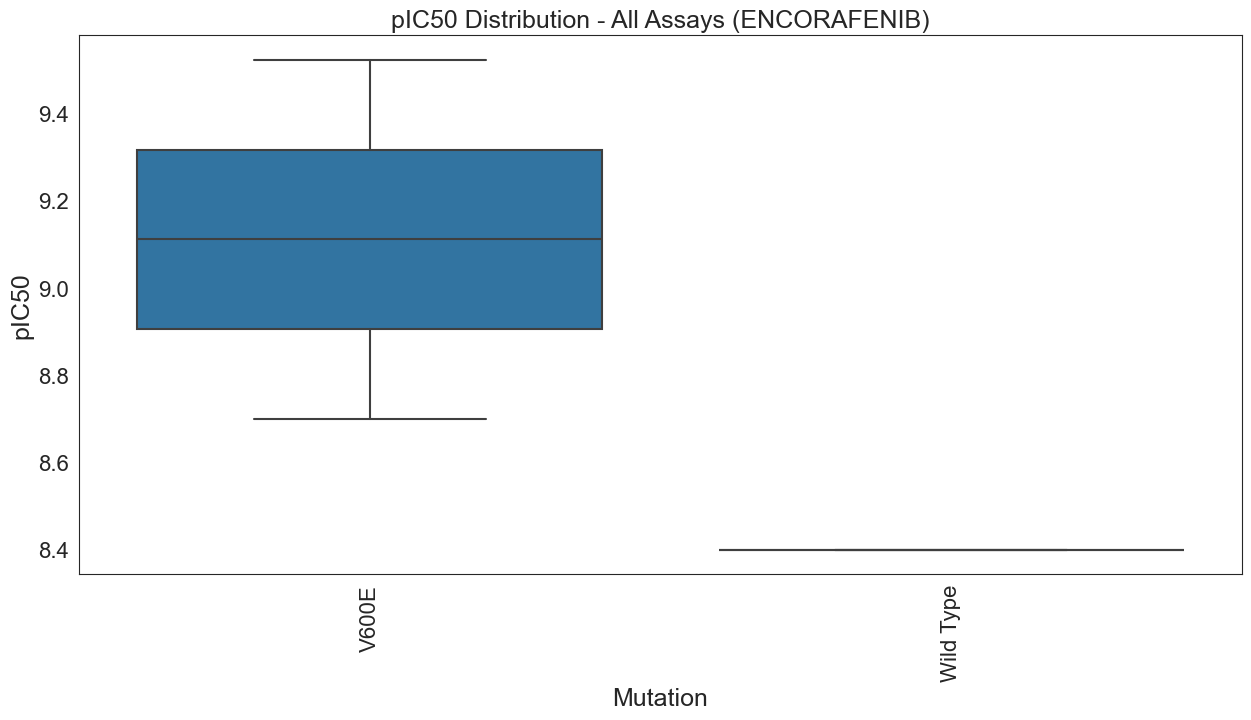

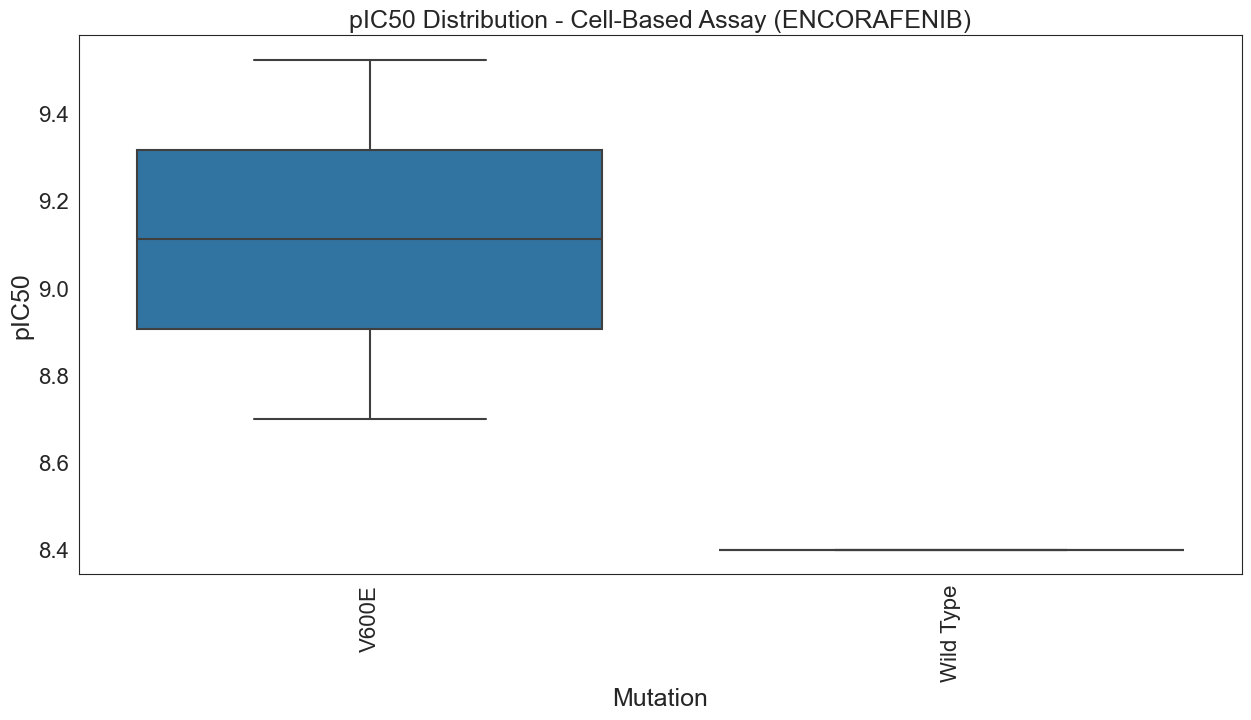

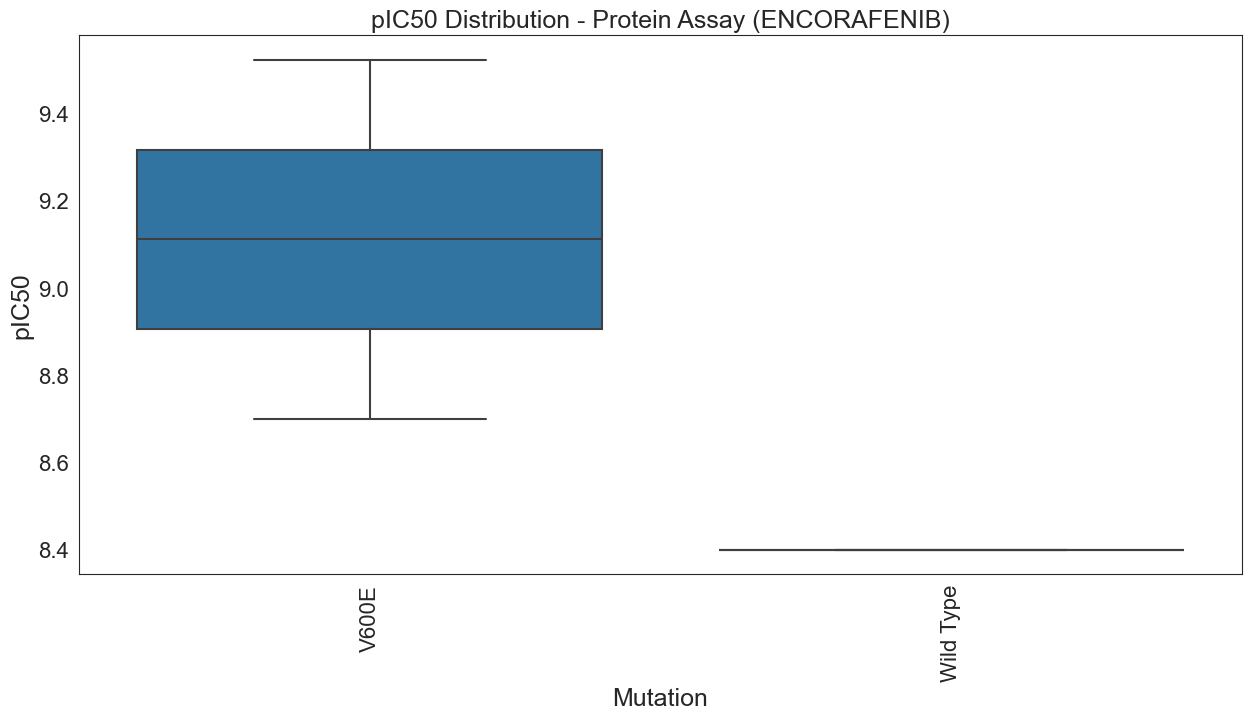

Plots saved successfully.


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.stats import mannwhitneyu

# 1) Use Seaborn’s “white” style (no gray background):
sns.set_style("white")

# 2) Make sure the figure and axes facecolors are truly white:
plt.rcParams["figure.facecolor"] = "white"

# Define file paths
fabian_file = (
    r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\Fabian_Literature_Review.csv"
)
cell_based_file = (
    r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\BRAF_IC50_all_assays.xlsx"
)
protein_file = (
    r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\BRAF_IC50_all_assays.xlsx"
)
all_assays_file = (
    r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\BRAF_IC50_all_assays.xlsx"
)

# Load Fabian Literature Review Data
encodings = ["ISO-8859-1"]
df_fabian = None

for enc in encodings:
    try:
        df_fabian = pd.read_csv(
            fabian_file, encoding=enc, engine="python", on_bad_lines="skip", sep=";"
        )
        print(f"Fabian data loaded successfully with encoding: {enc}")
        break
    except Exception as e:
        print(f"Failed with encoding: {enc}, error: {e}")

if df_fabian is None:
    raise ValueError("Failed to read the Fabian CSV file.")

df_fabian.columns = df_fabian.columns.str.strip()
df_fabian["TKI"] = df_fabian["TKI"].str.strip().str.upper()

df_fabian["Mean IC50/Kd (µM)"] = pd.to_numeric(
    df_fabian["Mean IC50/Kd (µM)"], errors="coerce"
)
df_fabian.dropna(subset=["Mean IC50/Kd (µM)"], inplace=True)
df_fabian["IC50_M"] = df_fabian["Mean IC50/Kd (µM)"] * 1e-6
df_fabian["pIC50"] = -np.log10(df_fabian["IC50_M"])

# Load Cell-Based, Protein Assay, and All Assays Data
df_cell_based = pd.read_excel(cell_based_file)
df_protein = pd.read_excel(protein_file)
df_all_assays = pd.read_excel(all_assays_file)  # New dataset


# Convert IC50 values to Molar and compute pIC50 for all datasets
def process_ic50_data(df, ic50_column):
    df[ic50_column] = pd.to_numeric(df[ic50_column], errors="coerce")
    df.dropna(subset=[ic50_column], inplace=True)
    df["IC50_M"] = df[ic50_column] * 1e-9  # Assuming IC50 is in nM
    df["pIC50"] = -np.log10(df["IC50_M"])
    return df


df_cell_based = process_ic50_data(df_cell_based, "standard_value")
df_protein = process_ic50_data(df_protein, "standard_value")
df_all_assays = process_ic50_data(
    df_all_assays, "standard_value"
)  # Process new dataset

# User selects TKI
available_tkis = sorted(df_fabian["TKI"].unique())
print("\nAvailable TKIs:", available_tkis)
selected_tki = input("Enter the TKI you want to analyze: ").strip()

# Filter data based on selected TKI
df_fabian_filtered = df_fabian[df_fabian["TKI"] == selected_tki]
df_cell_based["molecule_pref_name"] = (
    df_cell_based["molecule_pref_name"].str.strip().str.upper()
)
df_protein["molecule_pref_name"] = (
    df_protein["molecule_pref_name"].str.strip().str.upper()
)
df_all_assays["molecule_pref_name"] = (
    df_all_assays["molecule_pref_name"].str.strip().str.upper()
)

selected_tki = selected_tki.strip().upper()
df_cell_based_filtered = df_cell_based[
    df_cell_based["molecule_pref_name"] == selected_tki
]
df_protein_filtered = df_protein[df_protein["molecule_pref_name"] == selected_tki]
df_all_assays_filtered = df_all_assays[
    df_all_assays["molecule_pref_name"] == selected_tki
]  # New filter

# Statistical comparison for pIC50 between Wild Type and V600E
mutation_col = "assay_variant_mutation"

if selected_tki == "SORAFENIB":
    wt = df_all_assays_filtered[df_all_assays_filtered[mutation_col] == "Wild Type"]["pIC50"]
    v600e = df_all_assays_filtered[df_all_assays_filtered[mutation_col] == "V600E"]["pIC50"]
    
    if not wt.empty and not v600e.empty:
        stat, p = mannwhitneyu(wt, v600e, alternative='two-sided')
        print(f"\n📊 Mann–Whitney U Test for {selected_tki}:")
        print(f"U statistic = {stat:.2f}")
        print(f"P-value = {p:.4f}")
        if p < 0.05:
            print("✅ Statistically significant difference in pIC50 between Wild Type and V600E.")
        else:
            print("⚠️ No statistically significant difference in pIC50.")
    else:
        print("\n⚠️ Not enough data for Mann–Whitney U test on Wild Type vs V600E.")
        
        
if selected_tki == "ENCORAFENIB":
    wt = df_all_assays_filtered[df_all_assays_filtered[mutation_col] == "Wild Type"]["pIC50"]
    v600e = df_all_assays_filtered[df_all_assays_filtered[mutation_col] == "V600E"]["pIC50"]
    
    if not wt.empty and not v600e.empty:
        stat, p = mannwhitneyu(wt, v600e, alternative='two-sided')
        print(f"\n📊 Mann–Whitney U Test for {selected_tki}:")
        print(f"U statistic = {stat:.2f}")
        print(f"P-value = {p:.4f}")
        if p < 0.05:
            print("✅ Statistically significant difference in pIC50 between Wild Type and V600E.")
        else:
            print("⚠️ No statistically significant difference in pIC50.")
    else:
        print("\n⚠️ Not enough data for Mann–Whitney U test on Wild Type vs V600E.")


# Function to plot pIC50 distribution
def plot_pic50(df, x_column, title, filename):
    if df.empty:
        print(f"No data available for {title}")
        return
        # Turn OFF any grid lines (dots/lines) completely:
    plt.figure(figsize=(15, 7))
    sns.boxplot(data=df, x=x_column, y="pIC50", showfliers=False)
    plt.xticks(rotation=90, fontsize=16)
    plt.xlabel("Mutation", fontsize=18)
    plt.ylabel("pIC50", fontsize=18)
    plt.yticks(fontsize=16)
    plt.title(title, fontsize=18)
        # Turn OFF any grid lines (dots/lines) completely:
    plt.grid(False)
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# Plot and save figures
plot_pic50(
    df_fabian_filtered,
    "Mutation",
    f"pIC50 Distribution per EGFR Mutation ({selected_tki}) - Fabian Data",
    f"pIC50_Fabian_{selected_tki}.png",
)
plot_pic50(
    df_all_assays_filtered,
    "assay_variant_mutation",
    f"pIC50 Distribution - All Assays ({selected_tki})",
    f"pIC50_All_Assays_{selected_tki}.png",
)
plot_pic50(
    df_cell_based_filtered,
    "assay_variant_mutation",
    f"pIC50 Distribution - Cell-Based Assay ({selected_tki})",
    f"pIC50_Cell_Based_{selected_tki}.png",
)
plot_pic50(
    df_protein_filtered,
    "assay_variant_mutation",
    f"pIC50 Distribution - Protein Assay ({selected_tki})",
    f"pIC50_Protein_{selected_tki}.png",
)


print("Plots saved successfully.")

Fabian data loaded successfully with encoding: ISO-8859-1

Available TKIs: ['AEE788', 'AFATINIB', 'CL-387,785', 'DACOMITINIB', 'DY3002', 'ERLOTINIB', 'GEFITINIB', 'ICOTINIB', 'NERATINIB', 'OSIMERTINIB', 'ROCILETINIB', 'WZ3146', 'WZ4002', 'WZ4003', 'WZ8040']
No data available for pIC50 Distribution per EGFR Mutation (DABRAFENIB) - Fabian Data


c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


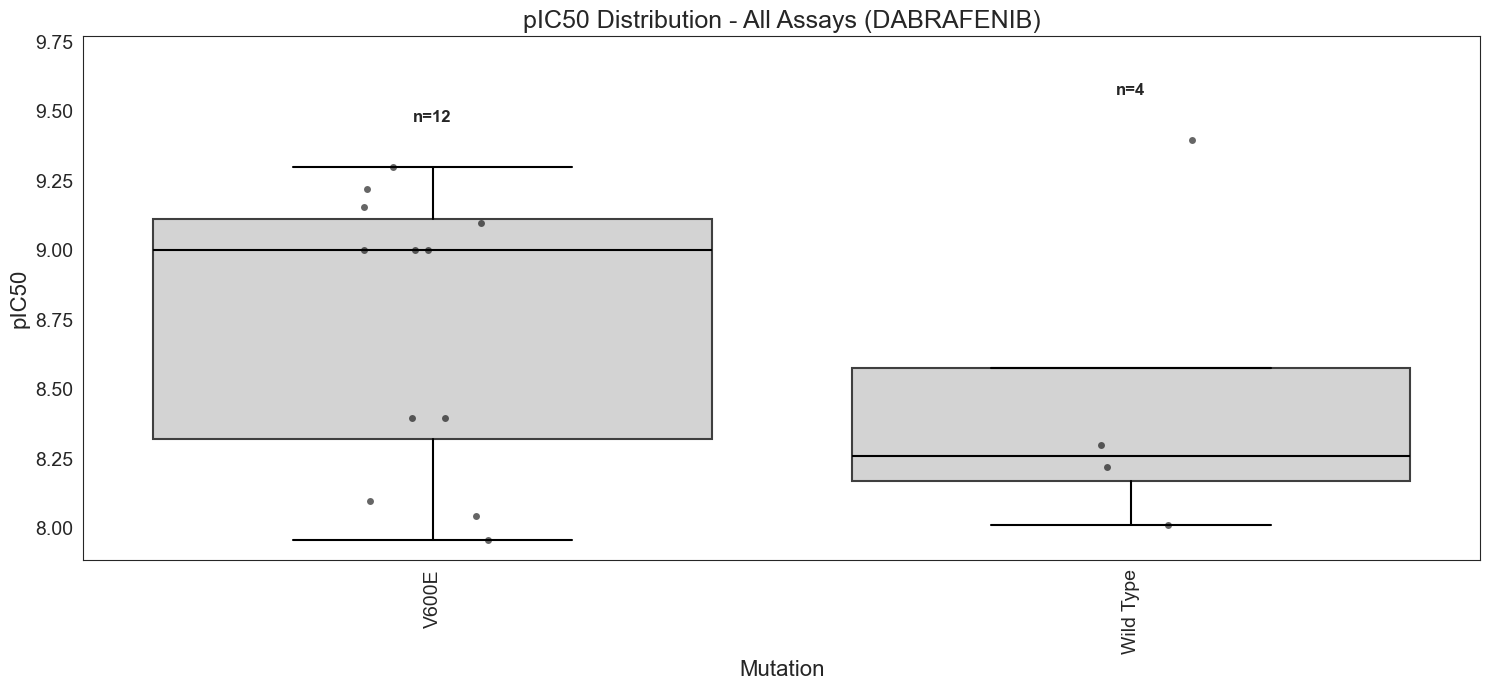

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


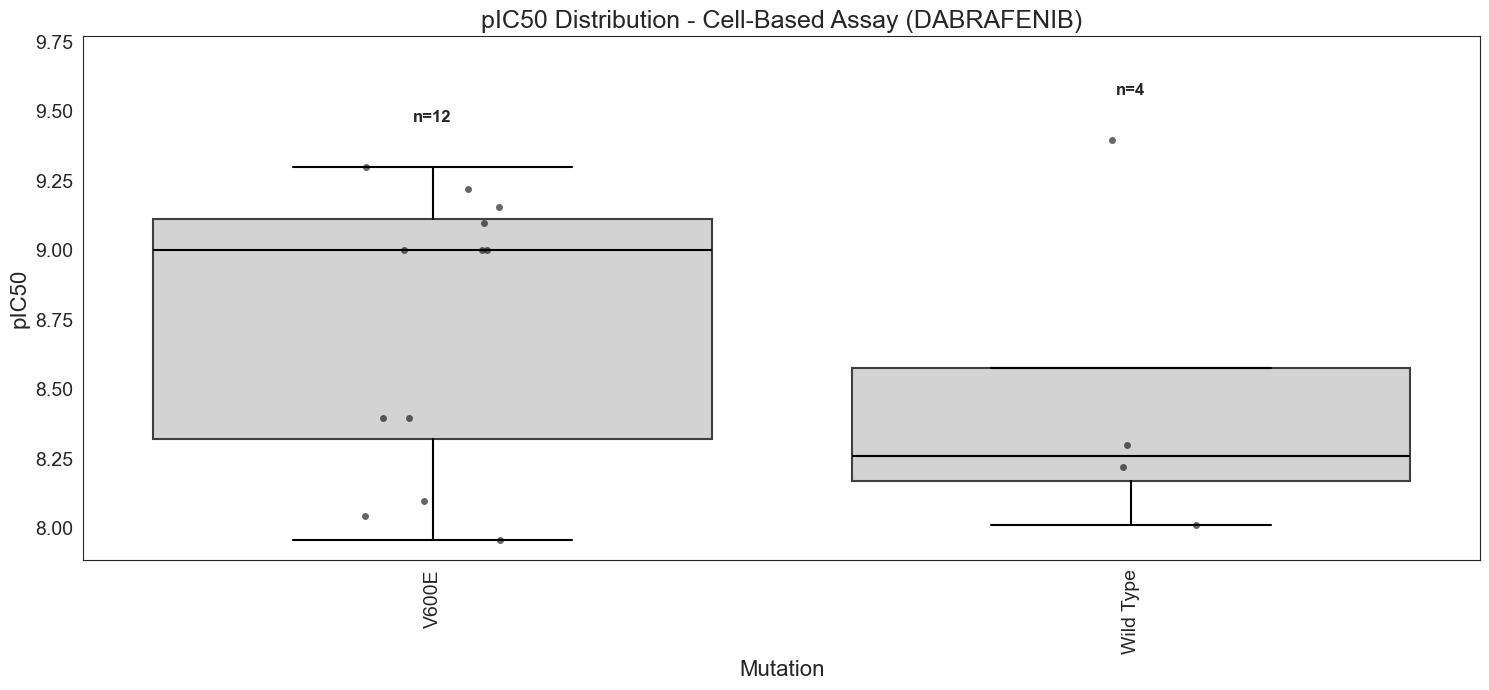

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


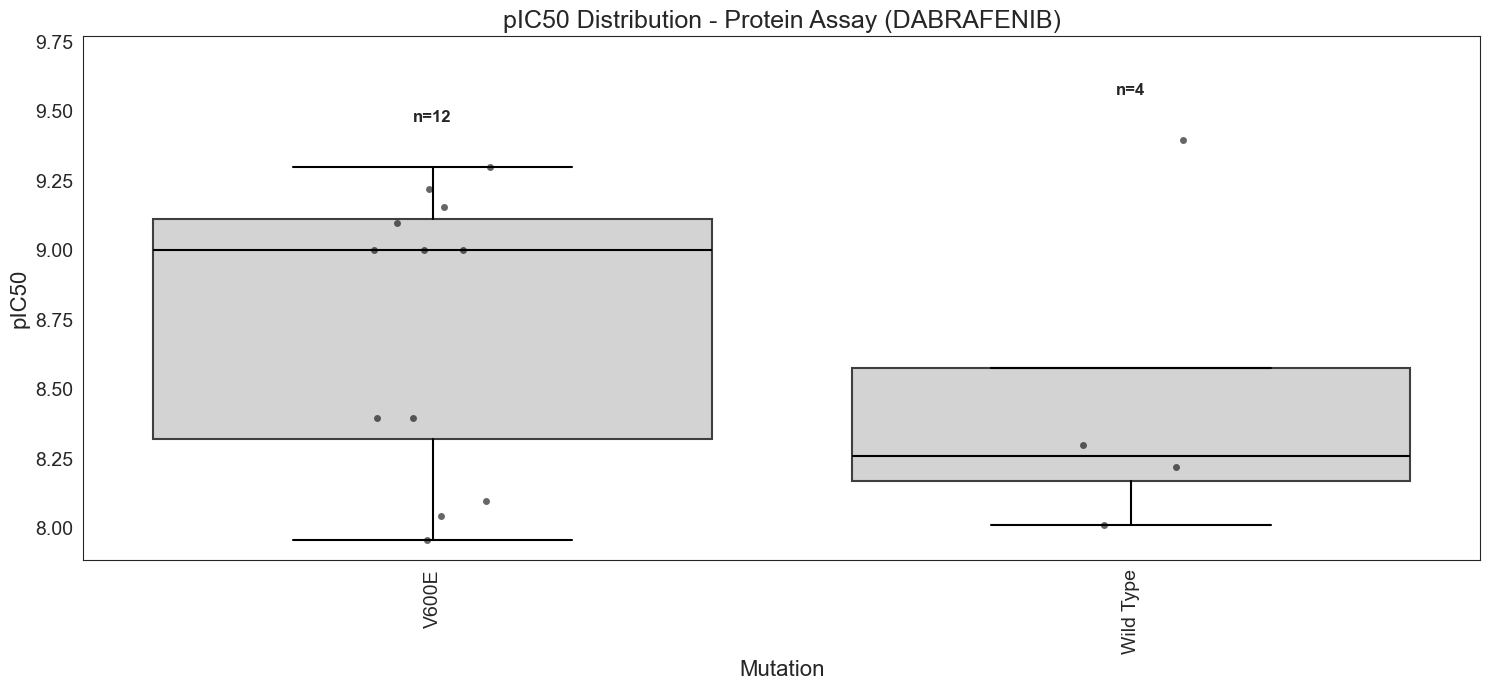

Plots saved successfully.


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.stats import mannwhitneyu

# 1) Use Seaborn’s “white” style (no gray background):
sns.set_style("white")

# 2) Make sure the figure and axes facecolors are truly white:
plt.rcParams["figure.facecolor"] = "white"

# Define file paths
fabian_file = (
    r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\Fabian_Literature_Review.csv"
)
cell_based_file = (
    r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\BRAF_IC50_all_assays.xlsx"
)
protein_file = (
    r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\BRAF_IC50_all_assays.xlsx"
)
all_assays_file = (
    r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\BRAF_IC50_all_assays.xlsx"
)

# --------------------------------------------------------------------
# Load Fabian Literature Review Data
# --------------------------------------------------------------------
encodings = ["ISO-8859-1"]
df_fabian = None

for enc in encodings:
    try:
        df_fabian = pd.read_csv(
            fabian_file, encoding=enc, engine="python", on_bad_lines="skip", sep=";"
        )
        print(f"Fabian data loaded successfully with encoding: {enc}")
        break
    except Exception as e:
        print(f"Failed with encoding: {enc}, error: {e}")

if df_fabian is None:
    raise ValueError("Failed to read the Fabian CSV file.")

df_fabian.columns = df_fabian.columns.str.strip()
df_fabian["TKI"] = df_fabian["TKI"].str.strip().str.upper()

df_fabian["Mean IC50/Kd (µM)"] = pd.to_numeric(
    df_fabian["Mean IC50/Kd (µM)"], errors="coerce"
)
df_fabian.dropna(subset=["Mean IC50/Kd (µM)"], inplace=True)
df_fabian["IC50_M"] = df_fabian["Mean IC50/Kd (µM)"] * 1e-6
df_fabian["pIC50"] = -np.log10(df_fabian["IC50_M"])

# --------------------------------------------------------------------
# Load Cell-Based, Protein Assay, and All Assays Data
# --------------------------------------------------------------------
df_cell_based = pd.read_excel(cell_based_file)
df_protein = pd.read_excel(protein_file)
df_all_assays = pd.read_excel(all_assays_file)  # New dataset

# Convert IC50 values to Molar and compute pIC50 for all datasets
def process_ic50_data(df, ic50_column):
    df[ic50_column] = pd.to_numeric(df[ic50_column], errors="coerce")
    df.dropna(subset=[ic50_column], inplace=True)
    df["IC50_M"] = df[ic50_column] * 1e-9  # Assuming IC50 is in nM
    df["pIC50"] = -np.log10(df["IC50_M"])
    return df

df_cell_based = process_ic50_data(df_cell_based, "standard_value")
df_protein    = process_ic50_data(df_protein,    "standard_value")
df_all_assays = process_ic50_data(df_all_assays, "standard_value")  # Process new dataset

# --------------------------------------------------------------------
# User selects TKI
# --------------------------------------------------------------------
available_tkis = sorted(df_fabian["TKI"].unique())
print("\nAvailable TKIs:", available_tkis)
selected_tki = input("Enter the TKI you want to analyze: ").strip().upper()

# Filter data based on selected TKI
df_fabian_filtered = df_fabian[df_fabian["TKI"] == selected_tki]

for df_temp in [df_cell_based, df_protein, df_all_assays]:
    df_temp["molecule_pref_name"] = (
        df_temp["molecule_pref_name"].str.strip().str.upper()
    )

df_cell_based_filtered = df_cell_based[
    df_cell_based["molecule_pref_name"] == selected_tki
]
df_protein_filtered = df_protein[
    df_protein["molecule_pref_name"] == selected_tki
]
df_all_assays_filtered = df_all_assays[
    df_all_assays["molecule_pref_name"] == selected_tki
]

# --------------------------------------------------------------------
# Statistical comparison for pIC50 between Wild Type and V600E (if Sorafenib)
# --------------------------------------------------------------------
mutation_col = "assay_variant_mutation"

if selected_tki == "SORAFENIB":
    wt    = df_all_assays_filtered[df_all_assays_filtered[mutation_col] == "Wild Type"]["pIC50"]
    v600e = df_all_assays_filtered[df_all_assays_filtered[mutation_col] == "V600E"]["pIC50"]
    
    if not wt.empty and not v600e.empty:
        stat, p = mannwhitneyu(wt, v600e, alternative='two-sided')
        print(f"\n📊 Mann–Whitney U Test for {selected_tki}:")
        print(f"U statistic = {stat:.2f}")
        print(f"P-value = {p:.4f}")
        if p < 0.05:
            print("✅ Statistically significant difference in pIC50 between Wild Type and V600E.")
        else:
            print("⚠️ No statistically significant difference in pIC50.")
    else:
        print("\n⚠️ Not enough data for Mann–Whitney U test on Wild Type vs V600E.")
        
if selected_tki == "VEMURAFENIB":
    wt    = df_all_assays_filtered[df_all_assays_filtered[mutation_col] == "Wild Type"]["pIC50"]
    v600e = df_all_assays_filtered[df_all_assays_filtered[mutation_col] == "V600E"]["pIC50"]
    
    if not wt.empty and not v600e.empty:
        stat, p = mannwhitneyu(wt, v600e, alternative='two-sided')
        print(f"\n📊 Mann–Whitney U Test for {selected_tki}:")
        print(f"U statistic = {stat:.2f}")
        print(f"P-value = {p:.4f}")
        if p < 0.05:
            print("✅ Statistically significant difference in pIC50 between Wild Type and V600E.")
        else:
            print("⚠️ No statistically significant difference in pIC50.")
    else:
        print("\n⚠️ Not enough data for Mann–Whitney U test on Wild Type vs V600E.")

# --------------------------------------------------------------------
# Function to plot pIC50 distribution (with overlaid points & N labels)
# --------------------------------------------------------------------
def plot_pic50(df, x_column, title, filename):
    if df.empty:
        print(f"No data available for {title}")
        return

    # Sort categories alphabetically (or choose any specific order you like)
    categories = sorted(df[x_column].dropna().unique())
    
    plt.figure(figsize=(15, 7))
    # Boxplot without “fliers”:
    sns.boxplot(
        data=df,
        x=x_column,
        y="pIC50",
        order=categories,
        showfliers=False,
        boxprops={"facecolor": "lightgray"},
        medianprops={"color": "black"},
        whiskerprops={"color": "black"},
        capprops={"color": "black"},
    )
    # Overlay all data points (jittered) in black:
    sns.stripplot(
        data=df,
        x=x_column,
        y="pIC50",
        order=categories,
        color="black",
        size=5,
        alpha=0.6,
        jitter=True,
    )

    # Compute counts and annotate “n=” above each box
    group_counts = df.groupby(x_column)["pIC50"].count().reindex(categories, fill_value=0)
    # Determine how high to put the text: use a little above each category’s max pIC50
    for i, cat in enumerate(categories):
        this_max = df[df[x_column] == cat]["pIC50"].max()
        # If there's only a single point, .max() == .min(); still works
        y_text = this_max + 0.15  # a small offset; adjust if needed
        n = int(group_counts.loc[cat])
        plt.text(
            i, y_text, f"n={n}",
            ha="center", va="bottom", fontsize=12, fontweight="bold"
        )

    # Remove any grid lines
    plt.grid(False)

    # Labels, title, rotation
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Mutation", fontsize=16)
    plt.ylabel("pIC50", fontsize=16)
    plt.title(title, fontsize=18)

    # Expand y-axis so “n=” labels do not get cut off
    current_ymin, current_ymax = plt.ylim()
    plt.ylim(current_ymin, current_ymax + 0.3)

    # Save + show
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# --------------------------------------------------------------------
# Plot and save figures (with the updated function)
# --------------------------------------------------------------------
plot_pic50(
    df_fabian_filtered,
    "Mutation",
    f"pIC50 Distribution per EGFR Mutation ({selected_tki}) - Fabian Data",
    f"pIC50_Fabian_{selected_tki}.png",
)
plot_pic50(
    df_all_assays_filtered,
    "assay_variant_mutation",
    f"pIC50 Distribution - All Assays ({selected_tki})",
    f"pIC50_All_Assays_{selected_tki}.png",
)
plot_pic50(
    df_cell_based_filtered,
    "assay_variant_mutation",
    f"pIC50 Distribution - Cell-Based Assay ({selected_tki})",
    f"pIC50_Cell_Based_{selected_tki}.png",
)
plot_pic50(
    df_protein_filtered,
    "assay_variant_mutation",
    f"pIC50 Distribution - Protein Assay ({selected_tki})",
    f"pIC50_Protein_{selected_tki}.png",
)

print("Plots saved successfully.")


📊 EGFR IC50 Comparison - Data Collection Tool/Literature Review- Protein Based (Structure-Based Drug Discovery/ Treatment Scoring) V2.0


Available Mutations (Fabian): ['A767-V769DUPASV', 'A864T', 'D747-753INSS', 'D761N', 'D770-N771INSNPG', 'DEL 746-A750', 'DEL 746-T751INSA', 'DEL 747-A750INSP', 'DEL 747-E749', 'DEL 747-L751INS S/T790M', 'DEL 747-P753INSS', 'DEL E746-A750', 'DEL E746-A750/PTEN DEL', 'DEL E746-A750/T790M', 'DEL E746-A750/T790M/C796S', 'DEL E746-E749/T790M', 'DEL E746-S752', 'DEL E746-S752INSV', 'DEL EX19', 'DEL EX19/C797S', 'DEL EX19/L792F', 'DEL EX19/L792Y', 'DEL EX19/T790M', 'DEL EX19/T790M/L792F', 'DEL EX19/T790M/L792H', 'DEL EX19/T790M/L792Y', 'DEL L747-A750INSP', 'DEL L747-E749', 'DEL L747-P753INSS', 'DEL L747-T751INSP', 'DEL S752-A750INSP', 'DEL S752-I759', 'DEL S752-I759/T790M', 'E746-S752DEL7INSV', 'E746-S752DEL7INSV/T790M', 'EGFR VIII', 'G719S', 'G719S-T790M', 'G810S', 'H773-V774INSH', 'L747-A750DEL4INSP', 'L747-A750DEL4INSP/T790M', 'L747-P753DEL7INSS', 'L747-P753DEL7INSS/T790M', 'L747P', 'L838V', 'L858R', 'L858R/C797S', 'L858R/L792F', 'L858R/L792H', 'L858R/T790M', 'L858R/T790M/C797S', 'L858R/T7

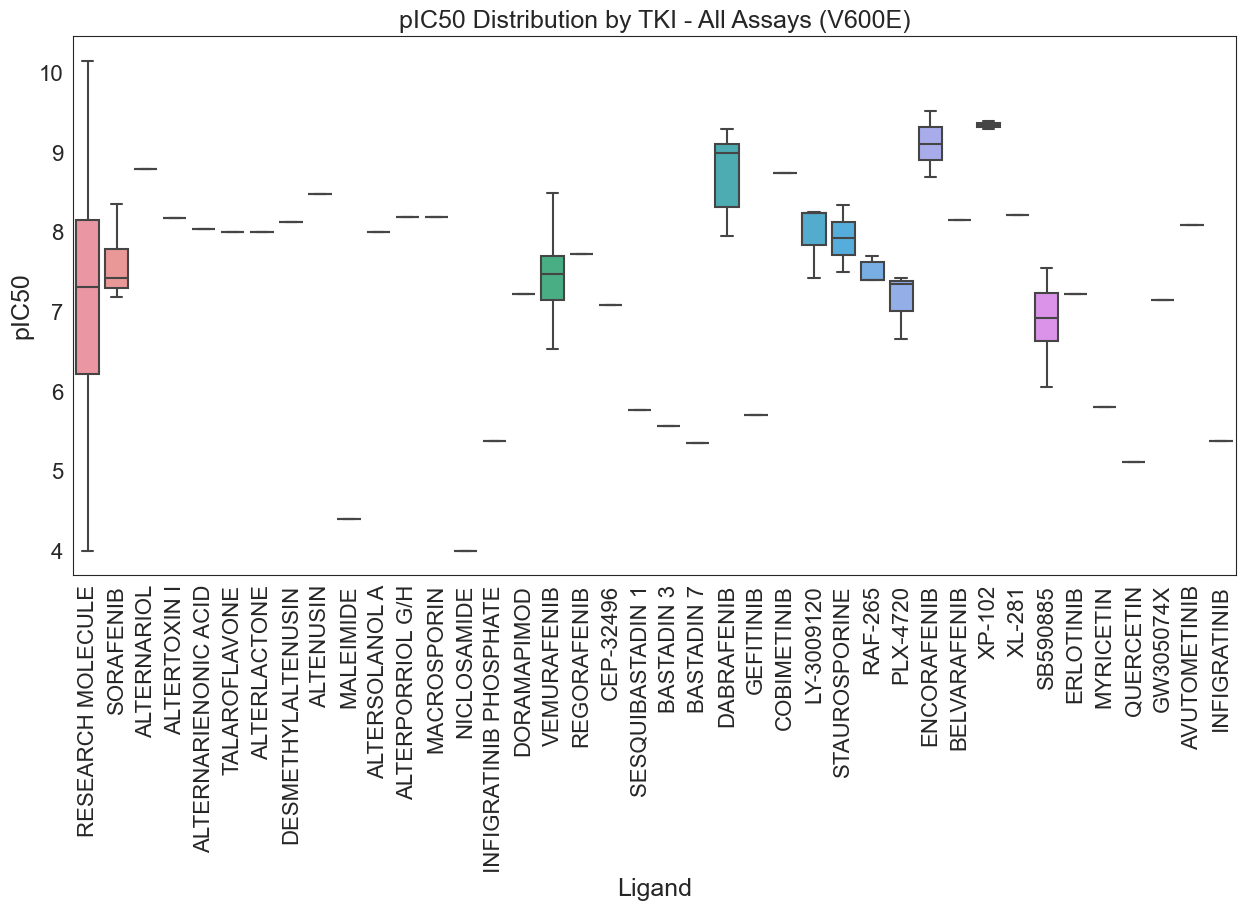

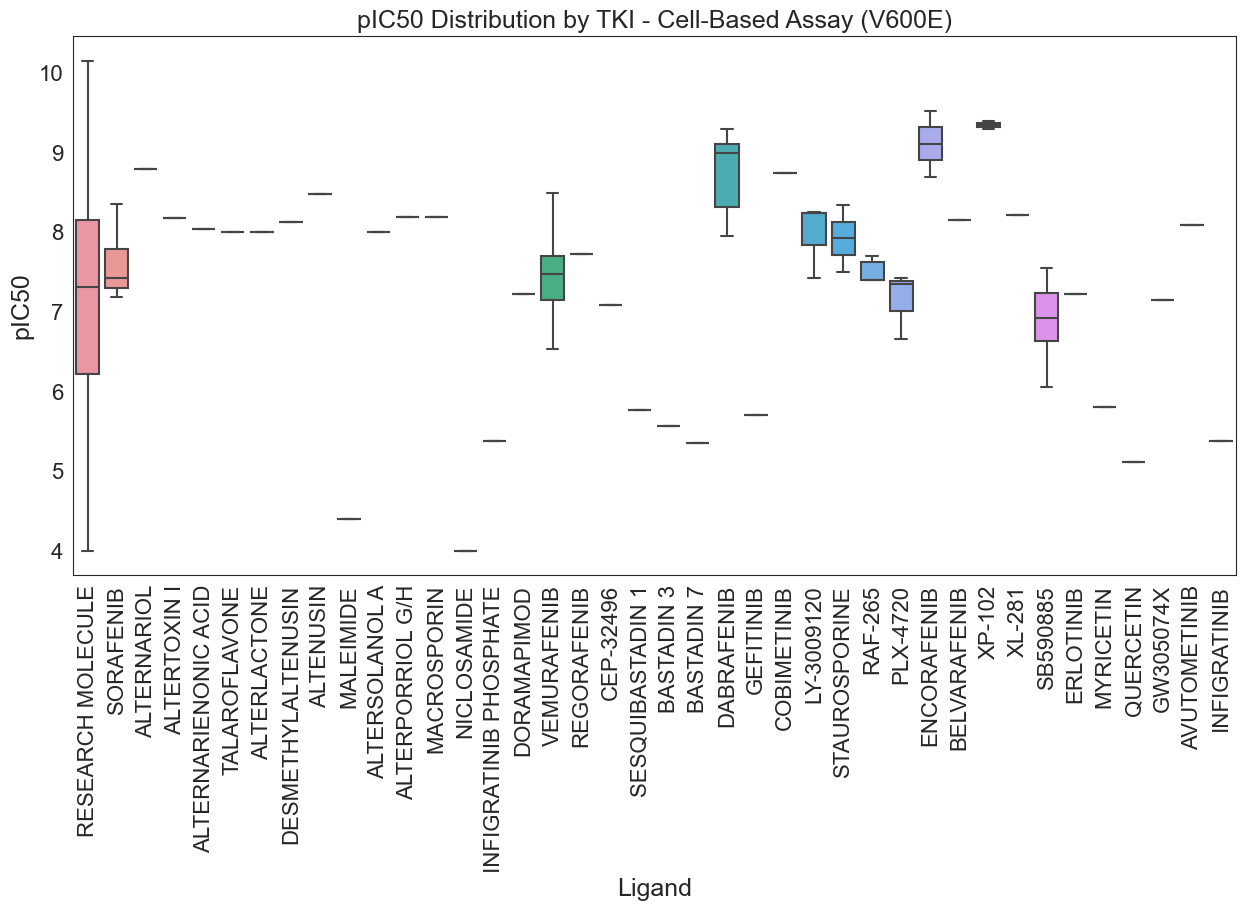

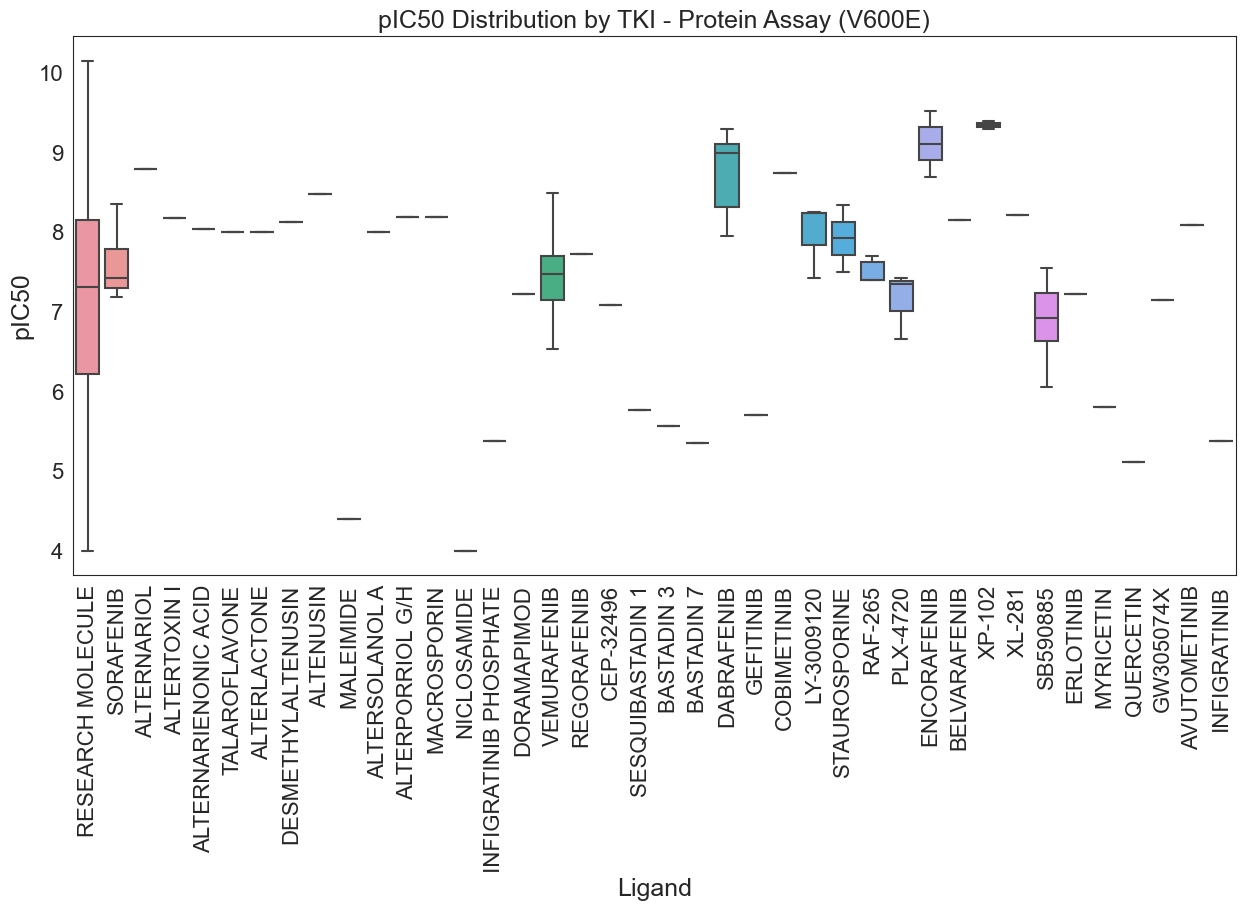

 Plots saved successfully.


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------------------------------------------------
# 1) File Paths (use raw strings to avoid backslash issues)
# -------------------------------------------------
# Define file paths
fabian_file = (
    r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\Fabian_Literature_Review.csv"
)
cell_based_file = (
    r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\BRAF_IC50_all_assays.xlsx"
)
protein_file = (
    r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\BRAF_IC50_all_assays.xlsx"
)
all_assays_file = (
    r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\BRAF_IC50_all_assays.xlsx"
)

# -------------------------------------------------
# 2) Load and Process Fabian Literature Review
# -------------------------------------------------
df_fabian = pd.read_csv(
    fabian_file,
    encoding="ISO-8859-1",  # or "latin-1" or "cp1252"
    engine="python",
    on_bad_lines="skip",
    sep=";"
)

# Make sure the "Mutation" column exists
if "Mutation" not in df_fabian.columns:
    raise ValueError("ERROR: 'Mutation' column is missing in Fabian data!")

# Make sure the "TKI" column exists
if "TKI" not in df_fabian.columns:
    raise ValueError("ERROR: 'TKI' column is missing in Fabian data!")

# Standardize "Mutation" column
df_fabian["Mutation"] = df_fabian["Mutation"].astype(str).str.strip().str.upper()

# Standardize "TKI" column
df_fabian["TKI"] = df_fabian["TKI"].astype(str).str.strip().str.upper()

# Drop rows with missing Mutation
df_fabian.dropna(subset=["Mutation"], inplace=True)

# Convert IC50 (µM) -> M, then compute pIC50
df_fabian["Mean IC50/Kd (µM)"] = pd.to_numeric(df_fabian["Mean IC50/Kd (µM)"], errors="coerce")
df_fabian.dropna(subset=["Mean IC50/Kd (µM)"], inplace=True)
df_fabian["IC50_M"] = df_fabian["Mean IC50/Kd (µM)"] * 1e-6
df_fabian["pIC50"] = -np.log10(df_fabian["IC50_M"])

# -------------------------------------------------
# 3) Load and Process Excel Data (Cell-Based, Protein, All Assays)
# -------------------------------------------------
df_cell_based = pd.read_excel(cell_based_file)
df_protein = pd.read_excel(protein_file)
df_all_assays = pd.read_excel(all_assays_file)

def process_ic50_data(df, ic50_column):
    df[ic50_column] = pd.to_numeric(df[ic50_column], errors="coerce")
    df.dropna(subset=[ic50_column], inplace=True)
    df["IC50_M"] = df[ic50_column] * 1e-9  # Convert nM to M
    df["pIC50"] = -np.log10(df["IC50_M"])
    return df

df_cell_based = process_ic50_data(df_cell_based, "standard_value")
df_protein = process_ic50_data(df_protein, "standard_value")
df_all_assays = process_ic50_data(df_all_assays, "standard_value")

# -------------------------------------------------
# 4) Standardize the Key Columns in Excel Data
#    - "assay_variant_mutation" for the mutation
#    - "molecule_pref_name" for the compound/TKI name
# -------------------------------------------------
for df_excel in [df_cell_based, df_protein, df_all_assays]:
    if "assay_variant_mutation" in df_excel.columns:
        df_excel["assay_variant_mutation"] = (
            df_excel["assay_variant_mutation"].astype(str).str.strip().str.upper()
        )
    else:
        print("Warning: 'assay_variant_mutation' column missing in one dataset.")

    if "molecule_pref_name" in df_excel.columns:
        df_excel["molecule_pref_name"] = (
            df_excel["molecule_pref_name"].astype(str).str.strip().str.upper()
        )
    else:
        print("Warning: 'molecule_pref_name' column missing in one dataset.")

# -------------------------------------------------
# 5) User Selects Mutation
# -------------------------------------------------
available_mutations = sorted(df_fabian["Mutation"].unique())
print("\nAvailable Mutations (Fabian):", available_mutations)
selected_mutation = input("Enter the Mutation you want to analyze: ").strip().upper()
print(f"User selected mutation: {selected_mutation}")

# Filter Fabian by "Mutation"
df_fabian_filtered = df_fabian[df_fabian["Mutation"] == selected_mutation]
if df_fabian_filtered.empty:
    # Try partial match
    df_fabian_filtered = df_fabian[
        df_fabian["Mutation"].str.contains(selected_mutation, na=False, regex=False)
    ]

# Filter Excel data by "assay_variant_mutation"
df_cell_based_filtered = pd.DataFrame()
if "assay_variant_mutation" in df_cell_based.columns:
    df_cell_based_filtered = df_cell_based[
        df_cell_based["assay_variant_mutation"] == selected_mutation
    ]

df_protein_filtered = pd.DataFrame()
if "assay_variant_mutation" in df_protein.columns:
    df_protein_filtered = df_protein[
        df_protein["assay_variant_mutation"] == selected_mutation
    ]

df_all_assays_filtered = pd.DataFrame()
if "assay_variant_mutation" in df_all_assays.columns:
    df_all_assays_filtered = df_all_assays[
        df_all_assays["assay_variant_mutation"] == selected_mutation
    ]

# -------------------------------------------------
# 6) Plotting Function
#    - x_column can be "TKI" (Fabian) or "molecule_pref_name" (Excel)
# -------------------------------------------------
def plot_pic50_by_molecule(df, x_column, title, filename):
    if df.empty:
        print(f"No data available for {title}")
        return
    plt.figure(figsize=(15, 7))
    sns.boxplot(data=df, x=x_column, y="pIC50", showfliers=False)
    plt.xticks(rotation=90, fontsize=16)
    plt.xlabel("Ligand", fontsize=18)
    plt.ylabel("pIC50", fontsize=18)
    plt.yticks(fontsize=16)
    plt.title(title, fontsize=18)
    # Turn OFF any grid lines (dots/lines) completely:
    plt.grid(False)
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# -------------------------------------------------
# 7) Generate and Save Plots
# -------------------------------------------------
# Fabian data: x-axis = "TKI" (show distribution by TKI for the selected mutation)
plot_pic50_by_molecule(
    df_fabian_filtered,
    "TKI",
    f"pIC50 Distribution by TKI - Fabian Data ({selected_mutation})",
    f"pIC50_Fabian_{selected_mutation}.png",
)

# Excel data: x-axis = "molecule_pref_name"
# (so we can see how different TKIs perform against the same mutation)
plot_pic50_by_molecule(
    df_all_assays_filtered,
    "molecule_pref_name",
    f"pIC50 Distribution by TKI - All Assays ({selected_mutation})",
    f"pIC50_All_Assays_{selected_mutation}.png",
)
plot_pic50_by_molecule(
    df_cell_based_filtered,
    "molecule_pref_name",
    f"pIC50 Distribution by TKI - Cell-Based Assay ({selected_mutation})",
    f"pIC50_Cell_Based_{selected_mutation}.png",
)

plot_pic50_by_molecule(
    df_protein_filtered,
    "molecule_pref_name",
    f"pIC50 Distribution by TKI - Protein Assay ({selected_mutation})",
    f"pIC50_Protein_{selected_mutation}.png",
)

print(" Plots saved successfully.")




📊 Cross Validation with Genomics of Drug Sensitivity in Cancer

Available molecules (139 total): ['Research Molecule' 'CANERTINIB DIHYDROCHLORIDE' 'DAPH' 'LAVENDUSTIN C'
 'CGP-53353' 'QUERCETIN' 'GW680191X' 'ZD-4190' 'VANDETANIB' 'ERBSTATIN'
 'GEFITINIB' 'TRYPHOSTIN' 'GW282974X' 'ADENOSINE' 'CANERTINIB'
 'TYRPHOSTIN AG-1478' 'QUINAZOLINE' 'ERLOTINIB' 'CAFFEIC ACID' 'GENISTEIN'
 'OROBOL' 'PSI-TECTORIGENIN' 'alpha-CYANO-4-HYDROXYCINNAMIC ACID'
 'TYRPHOSTIN 47' 'APIGENIN' 'KAEMPFEROL' 'BIOCHANIN' 'LAVENDUSTIN A'
 'ACACETIN' 'PRUNETIN' 'LAVENDUSTIN B' 'FLAVONE' 'PARABEN' 'DAIDZEIN'
 'GENISTIN' 'COCHLIOBOLIC ACID' 'AC-480' 'ERLOTINIB HYDROCHLORIDE'
 'LAPATINIB DITOSYLATE' 'LINSITINIB' 'SUNITINIB' 'PELITINIB' 'LAPATINIB'
 'BACITRACIN' 'CAFFEIC ACID PHENETHYL ESTER' 'CANDESARTAN' 'BITHIONOL'
 'ASTEMIZOLE' '4-OCTYLPHENOL' 'EBASTINE' 'ECONAZOLE' 'GENTIAN VIOLET'
 'HEXACHLOROPHENE' 'FLUPHENAZINE' 'CETYLPYRIDINIUM BROMIDE' 'CATECHOL'
 'CIGLITAZONE' 'COLISTIN' 'CLOSANTEL' 'CLOTRIMAZOLE' 'DOBUTAMINE'
 'ENCLOMIPHENE' 'CHLORPROMAZINE' 'PERHEXILINE' 'PYROGALLOL' '

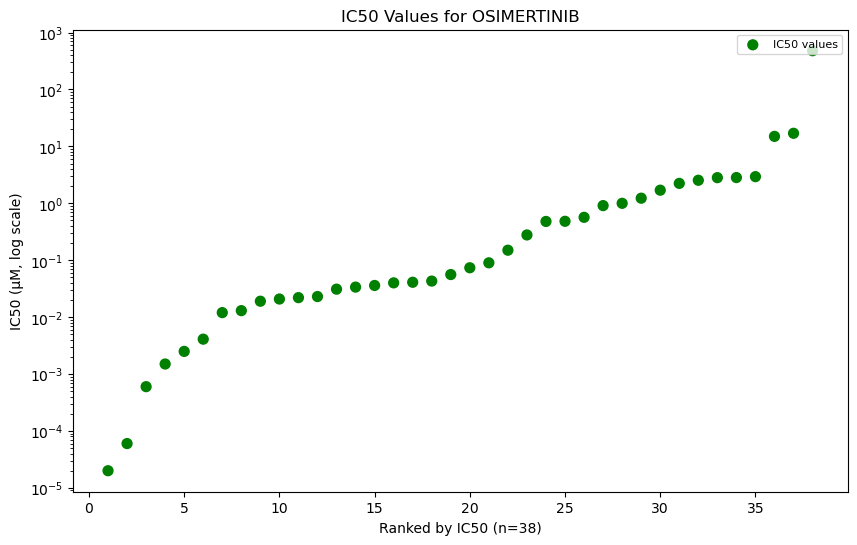

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the Excel file
file_path = r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\EGFR_IC50_cell_based.xlsx"
df = pd.read_excel(file_path)

# Ensure required columns exist
required_columns = ["molecule_pref_name", "standard_value"]
if not all(col in df.columns for col in required_columns):
    raise ValueError("Missing required columns in the Excel file!")

# Convert IC50 from nanomolar (nM) to micromolar (µM)
df["standard_value"] = pd.to_numeric(df["standard_value"], errors="coerce") / 1000
df.dropna(subset=["standard_value"], inplace=True)
df = df[df["standard_value"] > 0]

# Get unique molecules
unique_molecules = df["molecule_pref_name"].unique()
print(f"Available molecules ({len(unique_molecules)} total):", unique_molecules)

# Ask user to select a molecule (using case-insensitive matching)
selected_molecule = input("Enter the molecule name to plot: ").strip()
molecule_data = df[
    df["molecule_pref_name"].str.lower() == selected_molecule.lower()
].copy()

if molecule_data.empty:
    raise ValueError("Selected molecule not found in the dataset!")

# Sort IC50 values from lowest to highest and assign ranks
molecule_data.sort_values(by="standard_value", inplace=True)
num_data_points = len(molecule_data)
ranks = np.arange(1, num_data_points + 1)
ic50_values = molecule_data["standard_value"].values

# Color all points green
colors = ["green"] * num_data_points

# Create plot
plt.figure(figsize=(10, 6))
plt.scatter(ranks, ic50_values, c=colors, s=50, label="IC50 values")
plt.yscale("log")
plt.xlabel(f"Ranked by IC50 (n={num_data_points})")
plt.ylabel("IC50 (µM, log scale)")
plt.title(f"IC50 Values for {selected_molecule}")
plt.legend(fontsize=8, loc="upper right")

# Save and display the plot
filename = f"{selected_molecule.replace(' ', '_')}_IC50_plot.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

Available molecules (146): [nan 'CANERTINIB DIHYDROCHLORIDE' 'DAPH' 'LAVENDUSTIN C' 'CGP-53353'
 'QUERCETIN' 'GW680191X' 'ZD-4190' 'VANDETANIB' 'ERBSTATIN' 'GEFITINIB'
 'TRYPHOSTIN' 'GW282974X' 'ADENOSINE' 'CANERTINIB' 'TYRPHOSTIN AG-1478'
 'QUINAZOLINE' 'ERLOTINIB' 'CAFFEIC ACID' 'GENISTEIN' 'OROBOL'
 'PSI-TECTORIGENIN' 'alpha-CYANO-4-HYDROXYCINNAMIC ACID' 'TYRPHOSTIN 47'
 'APIGENIN' 'KAEMPFEROL' 'BIOCHANIN' 'LAVENDUSTIN A' 'ACACETIN' 'PRUNETIN'
 'LAVENDUSTIN B' 'FLAVONE' 'PARABEN' 'DAIDZEIN' 'GENISTIN'
 'COCHLIOBOLIC ACID' 'AC-480' 'ERLOTINIB HYDROCHLORIDE'
 'LAPATINIB DITOSYLATE' 'LINSITINIB' 'SUNITINIB' 'PELITINIB' 'LAPATINIB'
 'BACITRACIN' 'CADMIUM DICHLORIDE' 'CAFFEIC ACID PHENETHYL ESTER'
 'CANDESARTAN' 'BITHIONOL' 'ASTEMIZOLE' 'CADMIUM ACETATE' '4-OCTYLPHENOL'
 'EBASTINE' 'ECONAZOLE' 'GENTIAN VIOLET' 'HEXACHLOROPHENE'
 'GOLD SODIUM THIOMALATE' 'FLUPHENAZINE' 'CETYLPYRIDINIUM BROMIDE'
 'CHROMIC CHLORIDE' 'CATECHOL' 'CIGLITAZONE' 'CISPLATIN' 'COLISTIN'
 'CLOSANTEL' 'CLOTRIMAZOLE'

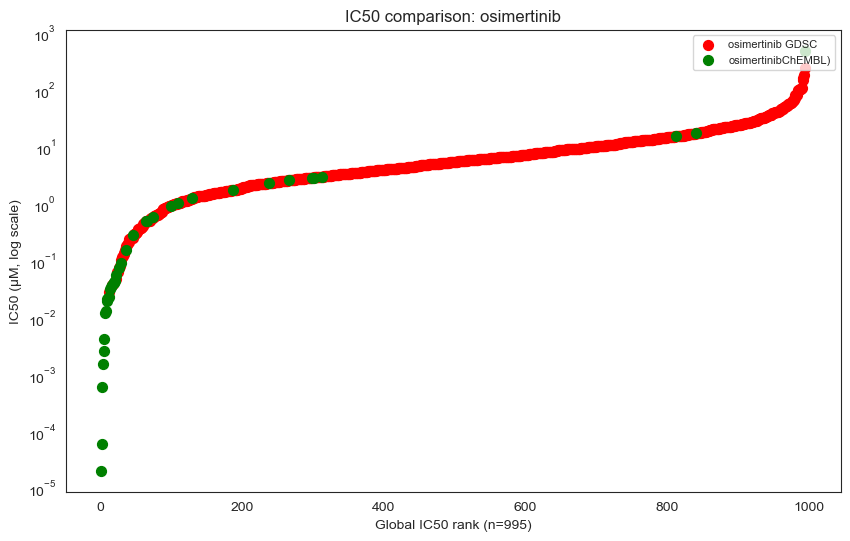

Plot saved to osimertinib_vs_Osimertinib_IC50_interleaved.png


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ── paths ───────────────────────────────────────────────────────────────
xlsx_path = Path(r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\master_project\EGFR_IC50_cell_based_data.xlsx")
gdsc_path = Path(r"C:\Users\ASUS\OneDrive\Escritorio\Repositories\osimertinib_ic50_gdsc2.csv")

# ── 1.  Load the “ChEMBL / EGFR” Excel file ─────────────────────────────
df = pd.read_excel(xlsx_path)

required_columns = ["molecule_pref_name", "standard_value"]
if not all(c in df.columns for c in required_columns):
    raise ValueError("Excel file is missing required columns.")

# Convert nM → µM for consistency
df["standard_value"] = pd.to_numeric(df["standard_value"], errors="coerce") / 1_000
df.dropna(subset=["standard_value"], inplace=True)
df = df[df["standard_value"] > 0]

# ── 2.  Load the “GDSC Osimertinib” CSV ─────────────────────────────────
if not gdsc_path.exists():
    raise FileNotFoundError(f"GDSC file not found at {gdsc_path}")

gdsc = pd.read_csv(gdsc_path)

# pick the IC50 column present in your CSV
if "IC50_MICROMOLAR" in gdsc.columns:
    gdsc_ic50 = gdsc["IC50_MICROMOLAR"]
elif "IC50_LOG10_MOLAR" in gdsc.columns:
    gdsc_ic50 = 10 ** gdsc["IC50_LOG10_MOLAR"]
elif "LN_IC50" in gdsc.columns:
    gdsc_ic50 = np.exp(gdsc["LN_IC50"])
else:
    raise ValueError("Cannot find an IC50 column in the GDSC file.")

gdsc_ic50 = gdsc_ic50[pd.to_numeric(gdsc_ic50, errors="coerce") > 0]

# ── 3.  Ask user which molecule from the Excel file to plot ─────────────
unique_mols = df["molecule_pref_name"].unique()
print(f"Available molecules ({len(unique_mols)}): {unique_mols}")

selected = input("Enter the molecule name to plot: ").strip()
mol_data = df[df["molecule_pref_name"].str.lower() == selected.lower()].copy()
if mol_data.empty:
    raise ValueError("Selected molecule not found in the Excel dataset.")


# ── 4.  Combine both datasets for a single ranking ──────────────
# ── 4.  Combine both datasets for a single ranking ──────────────
green_df0 = pd.DataFrame({"ic50": y_green, "source": "Excel"})
red_df0   = pd.DataFrame({"ic50": y_red,   "source": "GDSC"})

combined = pd.concat([green_df0, red_df0], ignore_index=True)
combined.sort_values("ic50", inplace=True)               # ascending potency
combined["rank"] = np.arange(1, len(combined) + 1)

green_df = combined[combined["source"] == "Excel"]
red_df   = combined[combined["source"] == "GDSC"]


# ── 5.  Plot (now with interleaved ranks) ───────────────────────
plt.figure(figsize=(10, 6))

# draw red first  → sits “behind”
plt.scatter(red_df["rank"],   red_df["ic50"],
            c="red", s=50, label="osimertinib GDSC")

# draw green second → on top
plt.scatter(green_df["rank"], green_df["ic50"],
            c="green", s=50, label=f"{selected}ChEMBL)")
plt.yscale("log")
plt.xlabel(f"Global IC50 rank (n={len(combined)})")
plt.ylabel("IC50 (µM, log scale)")
plt.title(f"IC50 comparison: {selected}")
plt.legend(fontsize=8, loc="upper right")

out_png = f"{selected.replace(' ', '_')}_vs_Osimertinib_IC50_interleaved.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()

print("Plot saved to", out_png)


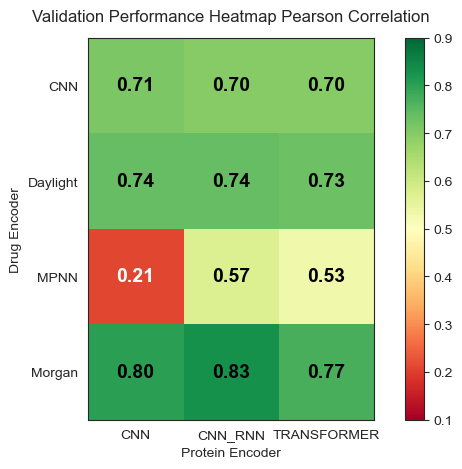

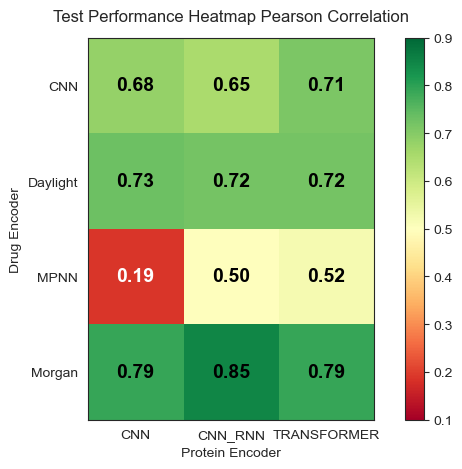

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1.  Data                      |
# ------------------------------
rows = ["CNN", "Daylight", "MPNN", "Morgan"]          # Drug encoders (y–axis)
cols = ["CNN", "CNN_RNN", "TRANSFORMER"]              # Protein encoders (x–axis)

val = np.array([
    [0.71, 0.70, 0.70],
    [0.74, 0.74, 0.73],
    [0.21, 0.57, 0.53],
    [0.80, 0.83, 0.77]
])

test = np.array([
    [0.68, 0.65, 0.71],
    [0.73, 0.72, 0.72],
    [0.19, 0.50, 0.52],
    [0.79, 0.85, 0.79]
])

# ------------------------------
# 2.  Helper                    |
# ------------------------------
def draw_heatmap(matrix, title):
    """
    Draw a single heat‑map with every cell annotated.
    Keeps default figure size (≈6.4×4.8 in) so dimensions don’t change.
    """
    fig, ax = plt.subplots()                # default size
    im = ax.imshow(matrix, cmap='RdYlGn', vmin=0.10, vmax=0.90)

    # Ticks & labels
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(rows)))
    ax.set_xticklabels(cols)
    ax.set_yticklabels(rows)
    ax.set_xlabel("Protein Encoder")
    ax.set_ylabel("Drug Encoder")
    ax.set_title(title, pad=12)

    # Annotate every cell
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            value = matrix[i, j]
            # White text on the darkest reds, black elsewhere
            text_color = "white" if value < 0.35 else "black"
            ax.text(j, i, f"{value:.2f}",
                    ha="center", va="center",
                    color=text_color,
                    fontsize=14, fontweight="bold")

    # Colour‑bar
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    return fig

# ------------------------------
# 3.  Render both heat‑maps     |
# ------------------------------
_ = draw_heatmap(val,  "Validation Performance Heatmap Pearson Correlation")
_ = draw_heatmap(test, "Test Performance Heatmap Pearson Correlation")


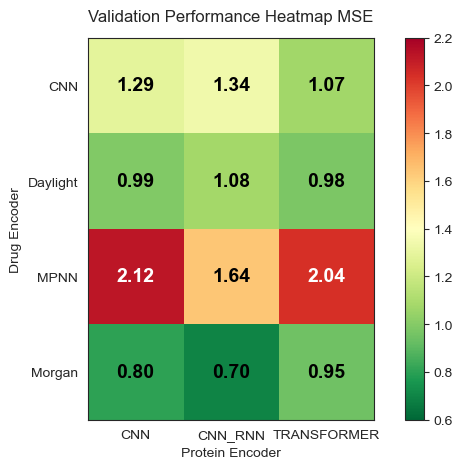

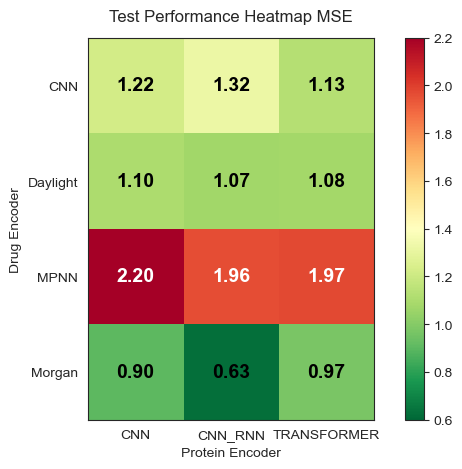

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1.  MSE data (validation & test) ---------------------------------
# ------------------------------------------------------------------
rows = ["CNN", "Daylight", "MPNN", "Morgan"]          # y-axis (drug encoders)
cols = ["CNN", "CNN_RNN", "TRANSFORMER"]              # x-axis (protein encoders)

mse_val = np.array([
    [1.29, 1.34, 1.07],
    [0.99, 1.08, 0.98],
    [2.12, 1.64, 2.04],
    [0.80, 0.70, 0.95]
])

mse_test = np.array([
    [1.22, 1.32, 1.13],
    [1.10, 1.07, 1.08],
    [2.20, 1.96, 1.97],
    [0.90, 0.63, 0.97]
])

# ------------------------------------------------------------------
# 2.  Helper: draw one heat-map ------------------------------------
# ------------------------------------------------------------------
def draw_heatmap(matrix, title):
    fig, ax = plt.subplots()                    # default figsize (~6.4×4.8 in)
    im = ax.imshow(matrix, cmap='RdYlGn_r', vmin=0.6, vmax=2.2)  # green = low MSE

    # Tick labels
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(rows)))
    ax.set_xticklabels(cols)
    ax.set_yticklabels(rows)
    ax.set_xlabel("Protein Encoder")
    ax.set_ylabel("Drug Encoder")
    ax.set_title(title, pad=12)

    # Annotate every cell
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            ax.text(j, i, f"{val:.2f}",
                    ha="center", va="center",
                    color="white" if val > 1.8 else "black",
                    fontsize=14, fontweight="bold")

    # Colour-bar
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# 3.  Render the two heat-maps -------------------------------------
# ------------------------------------------------------------------
draw_heatmap(mse_val,  "Validation Performance Heatmap MSE")
draw_heatmap(mse_test, "Test Performance Heatmap MSE")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data ---
try:
    # Adjust file paths/names as per uploaded files
    df_clinical = pd.read_csv("clinical data.xlsx - Sheet1.csv")
    df_ai       = pd.read_csv("fingerprint_cnn_rnn_sensitivity (1).xlsx - Sheet1.csv")
except FileNotFoundError:
    print("Ensure both 'clinical data.xlsx - Sheet1.csv' and 'fingerprint_cnn_rnn_sensitivity (1).xlsx - Sheet1.csv' exist.")
    exit()
except Exception as e:
    print(f"Error loading CSV files: {e}")
    exit()

# Immediately inspect columns to confirm the correct names:
print("Clinical data columns:", df_clinical.columns.tolist())
print("AI data columns:", df_ai.columns.tolist())

# --- 2. Prepare Clinical Data ---
# Updated mapping based on observed values in 'Prediction' column
clinical_response_mapping = {
    'sensitive': 'Sensitive',
    'no benefit': 'Resistant', # Assumption: 'no benefit' implies resistance. Adjust if needed.
    'unknown': 'Unknown',
    # Original script had:
    # 'Complete Response': 'Sensitive',
    # 'Partial Response':  'Sensitive',
    # 'Stable Disease':    'Intermediate',
    # 'Progressive Disease':'Resistant',
}

# Using the column name "Prediction" for clinical data response (identified from data inspection)
response_col = 'Prediction'
if response_col in df_clinical.columns:
    df_clinical['mapped_clinical_sensitivity'] = df_clinical[response_col].astype(str).map(clinical_response_mapping)
    # Fill NaN values that occurred before mapping (e.g. if original 'Prediction' was NaN)
    # AND values that didn't map (e.g. if 'Prediction' contained a value not in the map)
    df_clinical['mapped_clinical_sensitivity'].fillna('Unknown', inplace=True)
else:
    print(f"Error: Column '{response_col}' not found in clinical data file. Current columns: {df_clinical.columns.tolist()}")
    exit()

# --- 3. Prepare AI Data ---
# Mapping based on observed values in 'Sensitivity' column in AI data
ai_sensitivity_mapping = {
    'Sensitive': 'Sensitive',
    'Slightly Sensitive': 'Intermediate', # Maps "Slightly Sensitive" to "Intermediate"
    'Resistant': 'Resistant',
}

# Using the column name "Sensitivity" for AI data (identified from data inspection)
ai_data_sensitivity_col = 'Sensitivity'
if ai_data_sensitivity_col in df_ai.columns:
    df_ai['mapped_ai_sensitivity'] = df_ai[ai_data_sensitivity_col].astype(str).map(ai_sensitivity_mapping)
    df_ai['mapped_ai_sensitivity'].fillna('Unknown', inplace=True)
else:
    print(f"Error: Column '{ai_data_sensitivity_col}' not found in AI data file. Current columns: {df_ai.columns.tolist()}")
    exit()

# --- 4. Aggregate Data for Comparison ---
# Using 'Variant(s)' as the grouping column for clinical data.
# IMPORTANT: For a meaningful merge with AI data (by Drug), this column's values
# would need to align with AI drug names, or another clinical column representing drugs should be used.
clinical_grouping_col = 'Variant(s)' # Adjusted based on clinical data structure
if clinical_grouping_col not in df_clinical.columns:
    print(f"Error: Grouping column '{clinical_grouping_col}' not found in clinical data. Current columns: {df_clinical.columns.tolist()}")
    exit()
clinical_summary = (
    df_clinical
    .groupby(clinical_grouping_col)['mapped_clinical_sensitivity']
    .value_counts(normalize=True)
    .mul(100)
    .unstack(fill_value=0)
)

# Using 'Drug' as the grouping column for AI data (identified from data inspection)
ai_grouping_col = 'Drug'
if ai_grouping_col not in df_ai.columns:
    print(f"Error: Grouping column '{ai_grouping_col}' not found in AI data. Current columns: {df_ai.columns.tolist()}")
    exit()
ai_summary = (
    df_ai
    .groupby(ai_grouping_col)['mapped_ai_sensitivity']
    .value_counts(normalize=True)
    .mul(100)
    .unstack(fill_value=0)
)

# --- 5. Combine Summaries for Plotting ---
clinical_summary_renamed = clinical_summary.add_prefix('Clinical_')
ai_summary_renamed = ai_summary.add_prefix('AI_')

# Merging is done on the index of these summaries.
# clinical_summary index is 'Variant(s)'
# ai_summary index is 'Drug'
# An 'inner' merge will only keep items where 'Variant(s)' value matches a 'Drug' value.
# This is unlikely to produce many matches unless variant names are identical to drug names.
print(f"\nAttempting to merge clinical data (indexed by '{clinical_grouping_col}') with AI data (indexed by '{ai_grouping_col}').")
comparison_df = pd.merge(
    clinical_summary_renamed,
    ai_summary_renamed,
    left_index=True,
    right_index=True,
    how='inner' # Use 'outer' to keep all items, filling missing with 0
)
comparison_df.fillna(0, inplace=True)

if comparison_df.empty and (not clinical_summary.empty or not ai_summary.empty):
    print("\nWarning: Merged comparison DataFrame is empty.")
    print("This likely means no common identifiers were found between:")
    print(f"  - Clinical data index (from column '{clinical_grouping_col}'): {clinical_summary.index.unique().tolist()[:10]}...") # Show some example IDs
    print(f"  - AI data index (from column '{ai_grouping_col}'): {ai_summary.index.unique().tolist()[:10]}...") # Show some example IDs
    print("Please check if these columns should indeed be used for merging and if their contents are expected to match.")
    print("If they are not expected to match, an 'inner' merge will naturally be empty.")
    print("Consider using an 'outer' merge if you want to see all items from both datasets, or re-evaluate the grouping columns.\n")


# --- 6. Melt DataFrame for Grouped Bar Plotting ---
comparison_df_reset = comparison_df.reset_index()

# The first column after reset_index is the common identifier from the merge (e.g., Drug/Variant)
# We need to ensure this column has a consistent name for melting.
# The index name from the merge becomes the column name.
if not comparison_df_reset.empty:
    # If merge was on Variant(s) and Drug, and say 'Drug' was the name of index from right df
    # after reset_index, the column could be 'Drug' or 'Variant(s)' or 'index'
    # It's safer to get the first column name dynamically
    drug_col_after_reset = comparison_df_reset.columns[0]
    plot_df_melted = (
        comparison_df_reset
        .melt(
            id_vars=[drug_col_after_reset],
            var_name='Metric',
            value_name='Percentage'
        )
        .rename(columns={drug_col_after_reset: 'Identifier'}) # Standardize to 'Identifier'
    )

    # Split 'Metric' (e.g. 'Clinical_Sensitive') into 'Source' and 'Sensitivity_Category'
    plot_df_melted[['Source', 'Sensitivity_Category']] = (
        plot_df_melted['Metric']
        .str.split('_', n=1, expand=True)
    )

    # Define ordering of categories/sources for consistent plotting
    # Ensure all categories from your mappings are here if they can appear in summaries
    possible_categories = set(clinical_response_mapping.values()) | set(ai_sensitivity_mapping.values())
    common_categories = [cat for cat in ['Sensitive', 'Intermediate', 'Resistant', 'Unknown'] if cat in possible_categories]


    plot_df_melted['Sensitivity_Category'] = pd.Categorical(
        plot_df_melted['Sensitivity_Category'],
        categories=common_categories,
        ordered=True
    )
    plot_df_melted['Source'] = pd.Categorical(
        plot_df_melted['Source'],
        categories=['Clinical', 'AI'],
        ordered=True
    )

    # Drop rows where Sensitivity_Category might be NaN (if split didn't work as expected)
    # or not in common_categories, or if Source is NaN
    plot_df_melted.dropna(subset=['Sensitivity_Category', 'Source'], inplace=True)
    # Ensure categories are from the defined list after potential NaN drops from split
    plot_df_melted = plot_df_melted[plot_df_melted['Sensitivity_Category'].isin(common_categories)]
    plot_df_melted = plot_df_melted.sort_values(['Identifier', 'Sensitivity_Category', 'Source'])

else: # comparison_df_reset was empty
    plot_df_melted = pd.DataFrame() # Ensure plot_df_melted exists but is empty
    print("\nNo data to plot as the merged comparison DataFrame was empty. Exiting plotting routine.")


# --- 7. Create Graph ---
if not plot_df_melted.empty:
    num_identifiers = plot_df_melted['Identifier'].nunique()
    if num_identifiers == 0 : # Should not happen if plot_df_melted is not empty, but good check
        print ("\nNo identifiers found in the final data to plot. Check data processing steps.")
        # exit() # Exiting here might be too abrupt if only some categories are missing.
    else:
        g = sns.catplot(
            data=plot_df_melted,
            x='Identifier', # Changed from 'Drug' to 'Identifier'
            y='Percentage',
            hue='Source',
            col='Sensitivity_Category',
            kind='bar',
            col_wrap=min(2, len(common_categories) if common_categories else 1), # Adjust col_wrap
            height=5,
            aspect=max(0.6, min(2.0, (num_identifiers * 0.25 if num_identifiers > 0 else 1))),
            sharey=True,
            palette={'Clinical': 'skyblue', 'AI': 'coral'},
            dodge=True
        )
        g.set_xticklabels(rotation=45, ha='right')
        g.set_axis_labels("Identifier", "Percentage of Cases (%)") # Changed from "Drug"
        g.set_titles("Category: {col_name}")

        plt.subplots_adjust(top=0.9)
        g.fig.suptitle(
            "Clinical Outcome vs. AI Predicted Sensitivity by Identifier and Category",
            fontsize=16,
            y=0.98
        )
        try:
            plt.savefig("clinical_vs_ai_sensitivity_comparison.png", bbox_inches='tight')
            print("\nGraph saved as clinical_vs_ai_sensitivity_comparison.png")
            # plt.show() # Optionally show plot after saving
        except Exception as e:
            print(f"\nError saving graph: {e}")
            plt.show() # Attempt to show plot if saving fails
else:
    print(
        "\nNo common identifiers found or data available for plotting after all processing steps.\n"
        "Please carefully check:\n"
        "1. File paths and that files are readable CSVs.\n"
        f"2. Actual column name used for clinical response (expected '{response_col}').\n"
        f"3. Actual column name used for AI sensitivity (expected '{ai_data_sensitivity_col}').\n"
        f"4. Actual column names used for grouping (clinical: '{clinical_grouping_col}', AI: '{ai_grouping_col}').\n"
        "5. The content of your mapping dictionaries against the unique values in your data.\n"
        "6. Crucially, whether there are any common values between the clinical grouping column "
        f"('{clinical_grouping_col}') and the AI grouping column ('{ai_grouping_col}') if an 'inner' merge was used."
    )

# To help debug, print final processed data shape if it's small enough
if not plot_df_melted.empty:
    print(f"\nShape of final data for plotting: {plot_df_melted.shape}")
    if plot_df_melted.shape[0] < 20: # Print small dataframes
        print("Final data for plotting (plot_df_melted):")
        print(plot_df_melted)
elif comparison_df.empty:
     print("\nReminder: The merged DataFrame ('comparison_df') was empty, leading to no plot.")
else:
    print("\n'plot_df_melted' is empty, but 'comparison_df' was not. Problem in melting/post-processing.")

Clinical data columns: ['Variant(s)', 'n\xa0(%)\xa0a', 'Rationale', 'Prediction', 'LoE', 'Group']
AI data columns: ['Generation', 'Drug', 'Mutation', 'smiles', 'sequence', 'molecule_pref_name', 'wild_type_min', 'wild_type_max', 'wild_type_mean', 'canonical_smiles', 'drug_encoding', 'target_encoding', 'Label', 'Estimated_pIC50', 'Precision', 'MSE', 'Sensitivity']
Error: Grouping column 'treatment_regimen' not found in clinical data. Please verify based on printed column list.


KeyError: 'treatment_regimen'

: 